In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
column_interest = 'ATTRIBUTE_Bacteria'

#import quantification results
df = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Quantification/Quantification calculations/tables calculations/polynomial/histamine_experiment_IS_ratio_quantification.tsv', sep='\t')

#keep only the columns of interest
filtered_columns = [col for col in df.columns if '_x1' in col or col == 'filename']
df = df[filtered_columns]

# defininf numeric columns
numeric_cols = df.columns.difference(['filename'])

# Convert the numeric columns to numeric types
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Replace negative values with 0
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0, 0)

#import metadata
metadata = pd.read_csv('/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Quantification/Histamine_experiments/Histamine_experiment_metadata.txt', sep='\t')

#merge metadata
df = pd.merge(df, metadata[['filename', column_interest]])

#put merged column as first
last_column = df.iloc[:, -1]
df = pd.concat([last_column, df.iloc[:, :-1]], axis=1)

#organize the groups
priority_items = ['Blank_QC', 'Blank', 'Media_0h', 'Media_72h', 'Media+C+P+H_0h', 'Media+C+P+H_72h']

# Create a new column for sorting
df['sort_key'] = df[column_interest].apply(lambda x: priority_items.index(x) if x in priority_items else len(priority_items))

# Sort by this new column first, then by 'Bacteria' and drop the sort_key column
df = df.sort_values(by=['sort_key', column_interest])
df = df.drop(columns=['sort_key'])

#let's rename the columns
df.columns = df.columns.str.replace('_x1', '', regex=True)

df[column_interest] = df[column_interest].str.replace('_', ' ')
df[column_interest] = df[column_interest].str.replace('0h', '(0h) ')
df[column_interest] = df[column_interest].str.replace('72h', '(72h) ')

#Convert from µg/mL to mol/L (µM)

# Molecular masses in g/mol
histamine_c2 = 153.0902
histamine_c3 = 167.1059
histamine_c4 = 181.1372
histamine_c5 = 195.1372
cadaverine_c2 = 144.1263
cadaverine_c3 = 158.1419
cadaverine_c5 = 186.1732
cadaverine_c6 = 200.1889
dopamine_c2 = 195.0895

# Conversion factor: µg/mL to µM = (concentration in µg/mL) / (molecular mass in g/mol) * 1000
df['Histamine-C2:0 (µM)'] = df['Histamine-C2:0'] / histamine_c2 * 1000
df['Histamine-C3:0 (µM)'] = df['Histamine-C3:0'] / histamine_c3 * 1000
df['Histamine-C4:0 (µM)'] = df['Histamine-C4:0'] / histamine_c4 * 1000
df['Histamine-C5:0 (µM)'] = df['Histamine-C5:0'] / histamine_c5 * 1000
df['Cadaverine-C2:0 (µM)'] = df['Cadaverine-C2:0'] / cadaverine_c2 * 1000
df['Cadaverine-C3:0 (µM)'] = df['Cadaverine-C3:0'] / cadaverine_c3 * 1000
df['Cadaverine-C5:0 (µM)'] = df['Cadaverine-C5:0'] / cadaverine_c5 * 1000
df['Cadaverine-C6:0 (µM)'] = df['Cadaverine-C6:0'] / cadaverine_c6 * 1000
df['Dopamine-C2:0 (µM)'] = df['Dopamine-C2:0'] / dopamine_c2 * 1000

#keep only columns of interest
df = pd.concat([df.iloc[:, :2], df.filter(like="µM")], axis=1)

#and remove the ones that are Desulfovibrio piger (Dp) (we are not showing this one in the paper).
df = df[~df['filename'].str.contains('Dp_', na=False)]

ftable_filtered_merged = df.copy()
ordered_feature_names = df.columns.to_list()
ordered_feature_names = ordered_feature_names[2:]


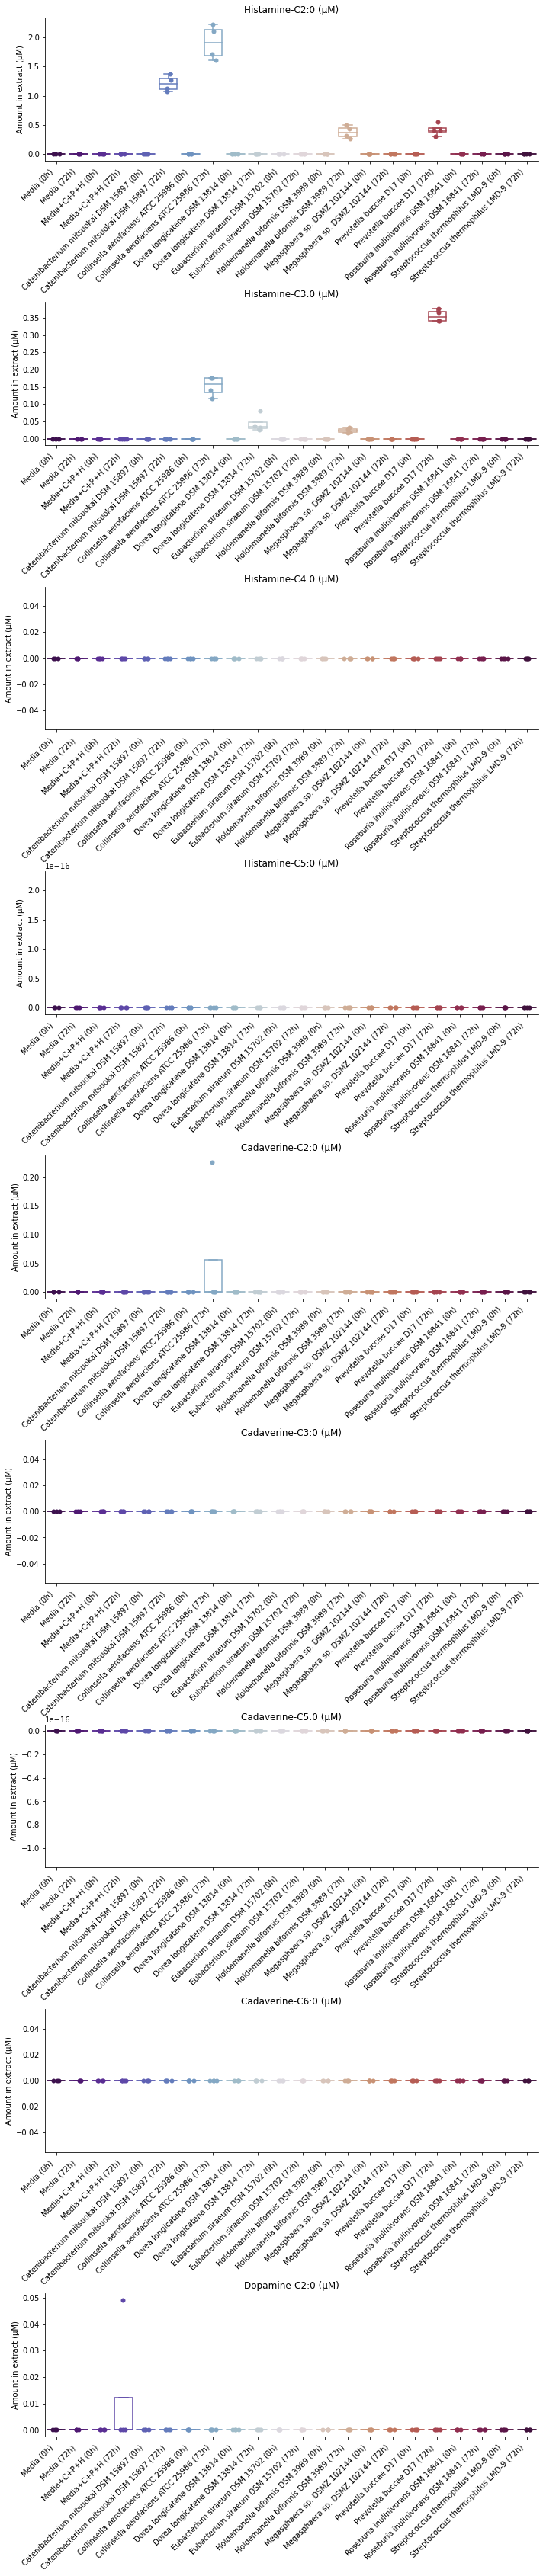

In [6]:
#plot
plt.figure(figsize=(10, 60))  # Adjust the figure size as needed

unique_values = ftable_filtered_merged[column_interest].unique().tolist()
ftable_filtered_merged[column_interest] = pd.Categorical(
    ftable_filtered_merged[column_interest], categories=unique_values, ordered=True)

# Function to generate a color palette
def generate_palette(n):
    return sns.color_palette("twilight_shifted", n)

# Assigning palette
my_pal = generate_palette(len(unique_values))
color_dict = {str(val): color for val, color in zip(unique_values, my_pal)}
color_dict_white = {key: 'white' for key in color_dict.keys()}

for i, feature_name in enumerate(ordered_feature_names, 1):
    title_name = feature_name
    plt.subplot(11, 1, i)
  
    fig = sns.boxplot(x=column_interest, y=feature_name, data=ftable_filtered_merged, notch=False, 
                      palette=color_dict_white, showfliers=False)    
    
    # Set box properties including edge color to match your palette
    for j, patch in enumerate(fig.artists):
        col = color_dict[ftable_filtered_merged[column_interest].unique()[j]]
        patch.set_edgecolor(col)

        num_lines = len(fig.lines)
        start_line_index = 5 * j
        end_line_index = start_line_index + 5
        for k in range(start_line_index, min(end_line_index, num_lines)):
            line = fig.lines[k]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Add colored dots for each category
    for diet in ftable_filtered_merged[column_interest].unique():
        sns.stripplot(
            x=column_interest, 
            y=feature_name, 
            data=ftable_filtered_merged[ftable_filtered_merged[column_interest] == diet], 
            color=color_dict[diet], 
            jitter=0.15, 
            size=6,
            ax=fig
        )
        
    # Rotate x-axis labels
    fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha='right')
    fig.set_ylabel(f'Amount in extract (µM)', fontsize=10)
    plt.title(f'{title_name}', fontsize=12) 
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    fig.set_xlabel('')
    
plt.tight_layout()
plt.subplots_adjust(top=0.91)
sns.despine()

# plt.savefig("/Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Quantification/Histamine_experiments/boxplots_quantification_micromolar_all_compounds.pdf")
plt.show()
